

# Initial Setup



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import math

# Set the seed for random operations. 
# Letting experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Dec 26 16:28:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image preprocessing function

In [ ]:
# Mask found in the HSV spectrum
MASK_LIMITS_HSV = ((30,40,70), (80,255,255))

In [ ]:
import cv2 as cv
# -----------------------------------------
# Image preprocessing (not used at the end)
# -----------------------------------------
def mask_image(image: np.array):
  
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    designed_mask = cv.inRange(image_hsv, *MASK_LIMITS_HSV)

    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    dilatated_mask = cv.dilate(denoised_mask, np.ones((5,5),np.uint8), iterations = 3)

    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

# Tiling functions

In [ ]:
import pandas as pd
import skimage.io as io
import glob
import sys
import os
import errno
import warnings
warnings.simplefilter("ignore", UserWarning)

def create_patches(img, patch_height=256, patch_width=256, h_stride=0.5, w_stride=0.5):
    """ 
        Params: img -> Input image(numpy array)
                patch height -> height of patch to be cut
                patch width -> width of patch to be cut
                h_stride -> 1/overlap required among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap required among adjacent patch along width
        input -> image (height,width,channel), patch dimensions
    	outpout -> patches of desired dimensions (patch_height, patch_width, channel)
                   patch parameters dictionary containing:
                                                          --original image height
                                                          --original image width
                                                          --stride along height
                                                          --stride along width
                                                          --patch height
                                                          --patch width
    """
    h_stride = int(max(1, patch_height * h_stride))
    w_stride = int(max(1, patch_width * w_stride))

    patch_param = {}
    patch_param['image_height'] = img.shape[0]
    patch_param['image_width'] = img.shape[1]
    patch_param['h_stride'] = h_stride
    patch_param['w_stride'] = w_stride
    patch_param['patch_height'] = patch_height
    patch_param['patch_width'] = patch_width

    h = 0
    w = 0

    img = pad_image(img, patch_height, patch_width)

    patches = []

    while h <= img.shape[0] - patch_height:
        w = 0
        while w <= img.shape[1] - patch_width:
            patches.append(img[h:h+patch_height, w:w+patch_width, :])
            w = w + w_stride
        h = h+h_stride

    return patches, patch_param

def return_padding(img, height, width):
    " Return padding given image and height, width of patch"
    h = 0 if img.shape[0]%height == 0 else height - img.shape[0]%height
    w = 0 if img.shape[1]%width == 0 else width - img.shape[1]%width
    pad_shape = tuple(np.zeros((len(img.shape),2),dtype=np.uint16))
    pad_shape = [tuple(x) for x in pad_shape]
    h_left  = h//2
    h_right = h - h_left
    w_left  = w//2
    w_right = w - w_left
    pad_shape[0] = (int(h_left),int(h_right))
    pad_shape[1] = (int(w_left),int(w_right))
    
    print("pad shape is {}".format(pad_shape))
    return pad_shape

def pad_image(img, height, width, channels=4, mode='constant'):
    """ 
        Pads img to make it fit for extracting patches of 
        shape height X width from it
        mode -> constant, reflect 
        constant -> pads ith 0's
        symmetric -> pads with reflection of image borders
    """
    print('input shape {}'.format(img.shape))
    pad_shape = return_padding(img, height, width)
    img = np.pad(img,pad_shape, mode='symmetric')
    print('output shape {}'.format(img.shape))
    return img  

def create_binary_mask(source, destination, dict_map = None, type = 'png'):
    """
    Takes source folder contating rgb ground truth masks
    and converts them to binary(grayscale) mask of each class
    destination folder will look like :
    ./destination/
        class-1/
            img1/
            img2/
            ..
            ..
            img9/
        class-2/
            img1/
            ..
            ..
            img9/
        ..
        Params: source -> source folder containing RGB masks
                destination -> destination folder where binary masks are to be saved
                dict_map -> dictionary mapping class and pixel values
                            for eg. dict_map = {
                                                'class1' : [255, 255, 255],
                                                'class2':  [0, 0, 0]
                                                }
                type -> type of image png, jpg, tif .
    """
    if not dict_map:
        raise Exception('Dictionary mapping not provided')
    assert isinstance(dict_map, (dict))
    assert type in ['png', 'jpg', 'tif']

    if source[-1] != '/':
        source = source + '/'
    if destination[-1] != '/':
        destination = destination + '/'

    if not os.path.isdir(source):
        raise Exception('source file does not exist')
    if not os.path.isdir(destination):
        print('creating destination folder')
        os.mkdir(destination)

    masks = glob.glob(source + '*.'+type)
    for key, rgb in dict_map.items():
        path = destination + key
        if not os.path.isdir(path):
            os.mkdir(path)
        for mask in masks:
            if type == 'tif':
                io.use_plugin('tifffile')
            img = io.imread(mask)
            img_id = mask.split('/')[-1].split('.')[0]
            
            class_mask = img[:,:,:] == np.array(rgb)
            final_mask = class_mask[...,0] * class_mask[...,1] * class_mask[...,2]
            final_mask = final_mask.astype(np.uint8)
            io.imsave(path + '/' + str(img_id) + '.' + type, final_mask)


def make_divisor_mask(mask_height, mask_width, step):
    
    """ Create a mask array defining the overlap extent of patches"""
    mask = np.empty([mask_height, mask_width], dtype=np.uint16)
    for i in range(1,mask_height+1):
        for j in range(1,mask_width+1):
            mask[i-1][j-1] = min(i,mask_height-i+1,step)*min(j,mask_width-j+1,step)
    return mask

def sortKeyFunc(s):
    return int(os.path.basename(s).split('_')[2])

def stitch_patch(patch_path, recon_img_path, image_dict, h_stride, w_stride, channel=3, type = 'png'):
    """
        Takes source folder containing patches of Images and reconstruct the original image by recombining
        the patches using naive overlapping assumption without any smoothing and saves them in destination
        NOTE: Patch files should be named like patch_i_j where i = Image number eg. 1,2,3,4 and j = Patch number
              eg. 1,2,3,4 etc. i.e. patch_i_j represent jth patch of ith image
        Params: patch_path -> source folder of patches
                recon_img_path -> destination folder of reconstructed image
                image_dict -> dictionary having image height, image width, patch height, patch width
                            with keys- 'image_height', 'image_width', 'patch_height', 'patch_width'
                h_stride -> 1/overlap taken among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap taken among adjacent patch along width
                channel  -> number of channel in patches
                type     -> type of patch 'png', 'jpg', 'tif'
    """
    
    if patch_path[-1] != '/':
        patch_path += '/'

    if not os.path.isdir(patch_path):
        raise Exception('patch directory does not exist')
    if not os.path.isdir(recon_img_path):
        print('creating destination folder')
        os.makedirs(destination)

    assert type in ['png', 'jpg', 'tif']
        
    patch_list = []
    i=1
    while True:
        patches = sorted(glob.glob(patch_path+'/patch_{}_*.tif'.format(i)), key=sortKeyFunc)
        if not patches:
            break
        patch_list.append(patches)
    for files in patch_list:
        if not files:
            continue
        else:
            patch_height = int(image_dict['patch_height'])
            patch_width  = int(image_dict['patch_height'])
            img_id = files[0].split('/')[-1].split('_')[1]
            orig_img_height = int(image_dict['image_height'])
            orig_img_width  = int(image_dict['image_width'])
            h_stride = int(h_stride*patch_height)
            w_stride = int(w_stride*patch_width)

            img_dtype = np.uint16
            image     = np.zeros((orig_img_height, orig_img_width, channel), dtype = img_dtype)
            padding   = return_padding(image, patch_height, patch_width)
            image     = pad_zeros(image, patch_height, patch_width, channel)
            h = 0
            w = 0
            patches = []
            patch_id =0
            for name in files:
                try:
                    if type == 'tif':
                        io.use_plugin('tifffile')
                    patch = io.imread(name)
                    patches.append(patch)
                    if image.dtype != patch.dtype:
                        image = image.astype(patch.dtype, copy=False)                        
                except OSError as e:
                    print(e.errno)
                    print("Some of the patches are corrupted")

            while h <= image.shape[0]-patch_height:
                w = 0
                while w <= image.shape[1]-patch_width:
                    image[h:h+patch_height, w:w+patch_width, :] += patches[patch_id]
                    w = w + w_stride
                    patch_id+=1
                h = h+h_stride
            if(h_stride==w_stride):
                step = patch_height//h_stride
            else:
                print("Unequal strides are not yet suppported")

            mask_height = image.shape[0]//h_stride
            mask_width  = image.shape[1]//w_stride
            divisor_mask = make_divisor_mask(mask_height, mask_width, step)
            print("Divisor mask shape {}".format(divisor_mask.shape))

            h = 0
            w = 0
            mask_h = 0
            mask_w = 0
            print("Image shape {}".format(image.shape))
            while h <= image.shape[0] - h_stride:
                w = 0
                mask_w = 0
                while w <= image.shape[1] - w_stride:
                    image[h:h+h_stride, w:w+w_stride,:] /= divisor_mask[mask_h,mask_w]
                    w += w_stride
                    mask_w +=1
                h += h_stride
                mask_h +=1

            img = image[padding[0][0]:-padding[0][1], padding[1][0]:-padding[1][1],:]
            print("FinalImage shape{}".format(img.shape))
            assert img.shape == (orig_img_height, orig_img_width, channel)

            if not os.path.isdir(recon_img_path):
                os.mkdir(recon_img_path)

            io.imsave(recon_img_path + '/' + str(img_id) + '.' + type, img)

# Dataset Retrieval

In [ ]:
# Option to be set to true the first time to RETRIEVE the dataset and split it
# into training and validation. If set to False it expects the dataset to be already 
# splitted and zipped in your drive in the directory "Challenge_2".
SPLIT_DATASET = True

# This option let you use your dataset_split.json file, that must be located in 
# your drive in the directory "Challenge_2", for the dataset split.
# Is considered only if SPLIT_DATASET == True since if SPLIT_DATASET == 
# False the dataset is expected to be already splitted and zipped in your
# drive in the directory "Challenge_2".
LOAD_FROM_JSON = True

### Cells executed if: SPLIT_DATASET = True 

In [ ]:
# ----------------------
# Get the zipped dataset 
# ----------------------
if SPLIT_DATASET == True:
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Challenge_2/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflati

In [ ]:
# -----------------------------
# Create the dataset_split.json 
# -----------------------------
if SPLIT_DATASET == True and LOAD_FROM_JSON == False:

  from PIL import Image
  import json
  
  VALIDATION_SPLIT = 0.15

  split = {}
  split['training'] = {}
  split['validation'] = {}

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  # Random seed for reproducibility
  np.random.seed(SEED)

  for t in teams:

    split['training'][t] = {}
    split['validation'][t] = {}

    for p in plants:

      split['training'][t][p] = []      
      split['validation'][t][p] = []

      image_filenames = os.listdir('/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Images')
      # Order images files to get always the same split
      image_filenames = sorted(image_filenames)
          
      # Create training split
      for i in range(int(len(image_filenames) * (1 - VALIDATION_SPLIT))):
        image_name = image_filenames[i].split('.')
        split['training'][t][p].append(image_name)
      
      # Create validation split
      for j in range(i + 1, len(image_filenames)):
        image_name = image_filenames[j].split('.')
        split['validation'][t][p].append(image_name)

  with open(os.path.join(cwd, 'dataset_split.json'), 'w') as f:
    json.dump(split, f)

  ! cp '/content/dataset_split.json' '/content/drive/My Drive/Challenge_2/dataset_split.json'

In [ ]:
# ------------------------------------------
# Create the splitted dataset directory tree 
# ------------------------------------------
if SPLIT_DATASET == True:
  import shutil
  
  # Use your dataset_split.json 
  # ---------------------------
  if LOAD_FROM_JSON == True:
    import json
    f = open('/content/drive/My Drive/Challenge_2/dataset_split.json')
    split = json.load(f) 
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'  
  # ---------------------------


  # Create the folder for the splitted dataset
  # ------------------------------------------
  ! mkdir '/content/Development_Dataset_processed'

  ! mkdir '/content/Development_Dataset_processed/training'
  ! mkdir '/content/Development_Dataset_processed/training/images'
  ! mkdir '/content/Development_Dataset_processed/training/masks'

  ! mkdir '/content/Development_Dataset_processed/validation'
  ! mkdir '/content/Development_Dataset_processed/validation/images'
  ! mkdir '/content/Development_Dataset_processed/validation/masks'
  # ------------------------------------------

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  which_dataset = ['training', 'validation']

  patch_split = {}
  patch_split['training'] = {}
  patch_split['validation'] = {}

  tile_width = 512
  tile_height = 512
  h_stride = 1
  w_stride = 1

  num_patch_tot = 0

  for d in which_dataset:
    
    for t in teams:

      patch_split[d][t] = {}
      
      for p in plants:

        patch_split[d][t][p] = []
        
        for img_name in split[d][t][p]:

          # Mask preprocessing and saving
          # -----------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Masks', img_name[0] + '.png')

          # Read Image
          mask = Image.open(src_path)
          
          # Image to np array
          mask_arr = np.array(mask)

          mask_patches, patch_param = create_patches(mask_arr, patch_height = tile_height, patch_width = tile_width, h_stride = h_stride, w_stride = w_stride)

          patches_to_use = []

          num_patch = 0
          for i in mask_patches:
            num_patch = num_patch + 1

            # RGB to target
            # -------------
            new_mask_arr = np.zeros(i.shape[:2], dtype=i.dtype)

            use_patch = False

            # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
            new_mask_arr[np.where(np.all(i == [0, 0, 0], axis=-1))] = 0
            new_mask_arr[np.where(np.all(i == [254, 124, 18], axis=-1))] = 0
            new_mask_arr[np.where(np.all(i == [255, 255, 255], axis=-1))] = 1
            new_mask_arr[np.where(np.all(i == [216, 67, 82], axis=-1))] = 2
            
            if (np.where(np.all(i == [255, 255, 255], axis=-1))[0].size != 0) or (np.where(np.all(i == [216, 67, 82], axis=-1))[0].size != 0):
              use_patch = True
              num_patch_tot = num_patch_tot + 1
              patches_to_use.append(num_patch)

            mask_arr = np.expand_dims(new_mask_arr, -1)

            # -------------
            if use_patch:
              dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'masks', img_name[0] + '_patch-' + str(num_patch) + '.npy')
              np.save(dst_path, mask_arr)
          # -----------------------------

          # Image preprocessing and saving
          # ------------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Images', img_name[0] + '.' + img_name[1])

          image = Image.open(src_path)

          # Image to np array
          img_array = np.array(image)
          
          img_patches, patch_param = create_patches(img_array, patch_height = tile_height, patch_width = tile_width, h_stride = h_stride, w_stride = w_stride)

          num_patch = 0
          for i in img_patches:

            num_patch = num_patch + 1

            if np.where(np.array(patches_to_use) == num_patch)[0].size != 0:
            
              img = Image.fromarray(i)
              dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'images', img_name[0] + '_patch-' + str(num_patch) + '.' + img_name[1])
              img.save(dst_path)
              patch_split[d][t][p].append([str(img_name[0] + '_patch-' + str(num_patch)), img_name[1]])

          # ------------------------------

  print(num_patch_tot)

  with open(os.path.join(cwd, 'dataset_split_patch.json'), 'w') as f:
    json.dump(patch_split, f)

  ! cp '/content/dataset_split_patch.json' '/content/drive/My Drive/Challenge_2/dataset_split_patch.json'

input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), 

In [ ]:
# ------------------------------------------------------------------------------------------
# Zip the splitted dataset for the next executions, to avoid the splitting process each time
# ------------------------------------------------------------------------------------------
if SPLIT_DATASET == True:
  ! zip -r '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip' 'Development_Dataset_processed'

### Cells executed if: SPLIT_DATASET = False 

In [ ]:
# --------------------------------------------------------------------------------
# Unzip the json file with the split used and the splitted dataset from your drive
# --------------------------------------------------------------------------------
if SPLIT_DATASET == False:
  # Get dataset_split.json
  ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'
  # Get dataset_split_patch.json
  ! cp '/content/drive/My Drive/Challenge_2/dataset_split_patch.json' '/content/dataset_split_patch.json'
  # Get the splitted dataset
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip'

input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)


12

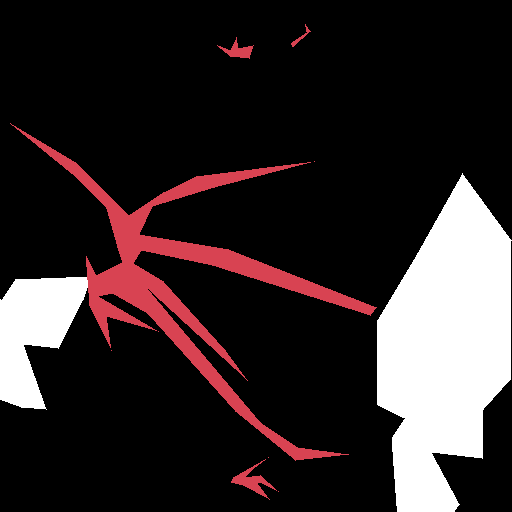

4

In [ ]:
# Read Image

mask = Image.open('/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_08371.png')
#display(mask)

# Image to np array
mask_arr = np.array(mask)

mask_patches, patch_param = create_patches(mask_arr, patch_height = 512, patch_width = 512, h_stride = 1, w_stride = 1)
len(mask_patches)

print()
print()
patches_to_use = []

num_patch = 0
for i in mask_patches:
  num_patch = num_patch + 1

  # RGB to target
  # -------------
  new_mask_arr = np.zeros(i.shape[:2], dtype=i.dtype)

  use_patch = False

  # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
  new_mask_arr[np.where(np.all(i == [0, 0, 0], axis=-1))] = 0
  new_mask_arr[np.where(np.all(i == [254, 124, 18], axis=-1))] = 0
  new_mask_arr[np.where(np.all(i == [255, 255, 255], axis=-1))] = 1
  new_mask_arr[np.where(np.all(i == [216, 67, 82], axis=-1))] = 2

  mask_arr = np.expand_dims(new_mask_arr, -1)

  if (np.where(np.all(i == [255, 255, 255], axis=-1))[0].size != 0) :
    use_patch = True
    patches_to_use.append(num_patch)
    #print(patches_to_use)
    if len(patches_to_use) == 3:
      #np.where(np.array(patches_to_use) == 6)[0].size
      display(Image.fromarray(i))
      
len(patches_to_use)

# Dataset Setup

In [ ]:
# -------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects
# -------------------------------------------------------------
def data_generator(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')

    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
    
  return img_data_gen, mask_data_gen

In [ ]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[500, 500]):
    import json
    
    subset_file = os.path.join('/content', 'dataset_split_patch.json')
    with open(subset_file, 'r') as f:
      split = json.load(f)
    
    teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
    plants = ['Haricot', 'Mais']
    
    subset_filenames = []
    
    for t in teams:
      for p in plants:
        
        for img_name in split[which_subset][t][p]:
          subset_filenames.append(img_name)
    
    np.random.seed(1234)
    np.random.shuffle(subset_filenames)

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.SEED = 1234

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, self.which_subset, 'images', curr_filename[0] + '.' + curr_filename[1]))
    mask_arr = np.load(os.path.join(self.dataset_dir, self.which_subset, 'masks', curr_filename[0] + '.npy'))   

    # Resize image and mask
    #img = img.resize(self.out_shape) #size – The requested size in pixels, as a 2-tuple: (width, height). ! ATTENTION ! PIL function
    #mask_arr = tf.image.resize(mask_arr, size = [self.out_shape[1], self.out_shape[0]], method = 'nearest').numpy()  # (height, width) since is a tensorflow function

    img_arr = np.array(img)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform

        #self.SEED = self.SEED + 1
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=self.SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, mask_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  dataset = CustomDataset('/content/Development_Dataset_processed',
                          'training', 
                          img_generator=img_data_gen, 
                          mask_generator=mask_data_gen,
                          out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Validation
  # ----------
  dataset_valid = CustomDataset('/content/Development_Dataset_processed',
                               'validation',
                               out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                               )
   
  valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  valid_dataset = valid_dataset.batch(bs)

  valid_dataset = valid_dataset.repeat()
  # ----------

  return train_dataset, dataset, valid_dataset, dataset_valid

# Data generator test

In [ ]:
# -------------------
# Data generator test
# -------------------

apply_data_augmentation = True

tmp_img_h = 1024
tmp_img_w = 1024

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = tmp_img_h, img_w = tmp_img_w, bs = 8, num_classes = 3)

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

In [ ]:
augmented_img, target = next(iterator)
augmented_img.shape
target.shape

TensorShape([8, 1024, 1024, 3])

TensorShape([8, 1024, 1024, 1])

[0. 2.]


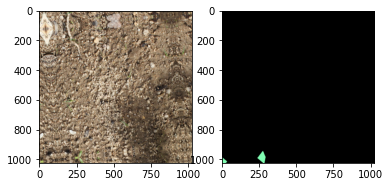

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# Model setup

## Models

### Braynet

In [214]:
def ConvolutionLayer(input, filters, kernel_size, strides, padding, batch_norm = False):

  conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, kernel_initializer = 'he_uniform')(input)
  if batch_norm:
    bn = tf.keras.layers.BatchNormalization(momentum=0.9)(conv)
  else:
    bn = conv
  out = tf.keras.layers.ELU()(bn)
  
  return out

In [215]:
def ResidualBlock(input, filters):
  
  conv1 = ConvolutionLayer(input = input, filters = int(filters/2), kernel_size = (1, 1), strides = (1, 1), padding = 'same')
  conv2 = ConvolutionLayer(input = conv1, filters = int(filters/2), kernel_size = (5, 1), strides = (1, 1), padding = 'same')
  conv3 = ConvolutionLayer(input = conv2, filters = int(filters/2), kernel_size = (1, 5), strides = (1, 1), padding = 'same')
  conv4 = ConvolutionLayer(input = conv3, filters = filters, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
  out = tf.keras.layers.Concatenate()([conv4, input])

  return out

In [216]:
def Braynet(input_shape = (896, 1280, 3)):
  efficient = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)
  
  # We only use: 
  # efficient.layers[:-3]
  
  input = efficient.input

  out_eff = efficient.get_layer('block7d_add').output

  # Up.Conv
  # -------
  skip_unpoolb7 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(out_eff)
  
  convb7 = ResidualBlock(skip_unpoolb7, filters = 512)
  # -------

  # Concat b6
  # -------
  skip_unpoolb6 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block6m_add').output)

  concatb6 = tf.keras.layers.Concatenate()([skip_unpoolb6, convb7])
  # -------

  # Conv + Upsampling
  # -------
  conv2 = ResidualBlock(concatb6, filters = 256)
  
  unpool2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv2)
  # -------


  # Concat b4
  # ---------
  skip_unpoolb4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block4g_add').output)

  concatb4 = tf.keras.layers.Concatenate()([skip_unpoolb4, unpool2])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv3 = ResidualBlock(concatb4, filters = 128)
  
  unpool3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv3)
  # ----------------- 
  
  # Concat b3
  # ---------
  skip_unpoolb3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block3g_add').output)

  concatb3 = tf.keras.layers.Concatenate()([skip_unpoolb3, unpool3])
  # ---------
  
  # Conv + Upsampling
  # -----------------
  conv4 = ResidualBlock(concatb3, filters = 64)
  
  unpool4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv4)
  # ----------------- 

  # Concat b2
  # ---------
  skip_unpoolb2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block2g_add').output)

  concatb2 = tf.keras.layers.Concatenate()([skip_unpoolb2, unpool4])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv5 = ResidualBlock(concatb2, filters = 16)
  
  unpool5 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv5)
  # ----------------- 

  output = tf.keras.layers.Conv2D(filters = 3, kernel_size= (1, 1), strides = (1, 1), activation = 'softmax')(unpool5)

  model = tf.keras.Model(inputs = input, outputs = output)
  
  model.summary()

  return model

### EfficientB7-Unet

In [217]:
def Efficient_Unet(input_shape = (896, 1280, 3)):
  efficient = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)
  
  # We only use: 
  # efficient.layers[:-3]
  
  input = efficient.input

  out_eff = efficient.get_layer('block7d_add').output

  # Up.Conv
  # -------
  skip_unpoolb7 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(out_eff)
  
  convb7 = tf.keras.layers.Conv2D(filters = 512, kernel_size=(3, 3), padding = 'same')(skip_unpoolb7)
  # -------

  # Concat b6
  # -------
  skip_unpoolb6 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block6m_add').output)

  concatb6 = tf.keras.layers.Concatenate()([skip_unpoolb6, convb7])
  # -------

  # Conv + Upsampling
  # -------
  conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same')(concatb6)
  
  unpool2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv2)
  # -------


  # Concat b4
  # ---------
  skip_unpoolb4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block4g_add').output)

  concatb4 = tf.keras.layers.Concatenate()([skip_unpoolb4, unpool2])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same')(concatb4)
  
  unpool3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv3)
  # ----------------- 
  
  # Concat b3
  # ---------
  skip_unpoolb3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block3g_add').output)

  concatb3 = tf.keras.layers.Concatenate()([skip_unpoolb3, unpool3])
  # ---------
  
  # Conv + Upsampling
  # -----------------
  conv4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same')(concatb3)
  
  unpool4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv4)
  # ----------------- 

  # Concat b2
  # ---------
  skip_unpoolb2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block2g_add').output)

  concatb2 = tf.keras.layers.Concatenate()([skip_unpoolb2, unpool4])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv5 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same')(concatb2)
  
  unpool5 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv5)
  # ----------------- 

  output = tf.keras.layers.Conv2D(filters = 3, kernel_size= (1, 1), strides = (1, 1), activation = 'softmax')(unpool5)

  model = tf.keras.Model(inputs = input, outputs = output)
  
  model.summary()

  return model

## Setup functions

In [218]:
def define_transfer_learning(input_size = (896, 1280, 3)):

  eff_unet_model = Efficient_Unet(input_shape = input_size)
  
  eff_unet_model.trainable = True

  train = False
  for layer in eff_unet_model.layers:
    if train:
      layer.trainable = True
    else:
      layer.trainable = False
    if layer.name == 'block7d_add':
      train = True

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  #eff_unet_model.summary()
  model.summary()

  return model

In [219]:
def define_fine_tuning(input_size = (896, 1280, 3)):

  eff_unet_model = Efficient_Unet(input_shape = input_size)

  eff_unet_model.trainable = True

  train = False

  for layer in eff_unet_model.layers:
  
    if train:
      layer.trainable = True
    else:
      layer.trainable = False
    
    if layer.name == 'block7d_add':
      train = True

    #if ("block4" in layer.name):
    #  layer.trainable = True
    
    #if ("block5" in layer.name):
    #  layer.trainable = True

    if ("block6" in layer.name):
      layer.trainable = True
    
    if ("block7" in layer.name):
      layer.trainable = True
    
    if "_bn" in layer.name:
      layer.trainable = False

    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  model.summary()

  return model

In [220]:
# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):

  # get predicted class from softmax
  y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

  per_class_iou = []

  for i in range(1,3): # exclude the background class 0

    # Get prediction and target related to only a single class (i)
    class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    per_class_iou.append(iou)

  return tf.reduce_mean(per_class_iou)

## Losses

In [221]:
def _gather_channels(x, indexes):
  """Slice tensor along channels axis by given indexes"""
    
  x = backend.permute_dimensions(x, (3, 0, 1, 2))
  x = backend.gather(x, indexes)
  x = backend.permute_dimensions(x, (1, 2, 3, 0))

def get_reduce_axes(per_image):
    
    axes = [1, 2]
    if not per_image:
        axes.insert(0, 0)
    return axes


def gather_channels(*xs, indexes=None):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes) for x in xs]
    return xs


def round_if_needed(x, threshold):
    
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x

def average(x, per_image=False, class_weights=None):

    if per_image:
        x = backend.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return backend.mean(x)

In [222]:
import keras.backend as backend

def f_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=1e-7, per_image=False, threshold=None):
    r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:
    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        F-score in range [0, 1]
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)
    pr = round_if_needed(pr, threshold)
    axes = get_reduce_axes(per_image)

    # calculate score
    tp = backend.sum(gt * pr, axis=axes)
    fp = backend.sum(pr, axis=axes) - tp
    fn = backend.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights)

    return score

In [223]:
def DiceLoss(y_true, y_pred):
    r"""Creates a criterion to measure Dice loss:
    .. math:: L(precision, recall) = 1 - (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: L(tp, fp, fn) = \frac{(1 + \beta^2) \cdot tp} {(1 + \beta^2) \cdot fp + \beta^2 \cdot fn + fp}
    where:
         - tp - true positives;
         - fp - false positives;
         - fn - false negatives;
    Args:
        beta: Float or integer coefficient for precision and recall balance.
        class_weights: Array (``np.array``) of class weights (``len(weights) = num_classes``).
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        per_image: If ``True`` loss is calculated for each image in batch and then averaged,
        else loss is calculated for the whole batch.
        smooth: Value to avoid division by zero.
    Returns:
        A callable ``dice_loss`` instance. Can be used in ``model.compile(...)`` function`
        or combined with other losses.
    Example:
    .. code:: python
        loss = DiceLoss()
        model.compile('SGD', loss=loss)
    """
    return 1 - f_score(
                        y_true,
                        y_pred,
                        beta=1,
                        class_weights=1,
                        class_indexes=None,
                        smooth=1e-7,
                        per_image=False,
                        threshold=None
                    )

In [224]:
def categorical_focal_loss(gt, pr, gamma=2.0, alpha=0.25, class_indexes=None):
    r"""Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = - gt * alpha * ((1 - pr)^gamma) * log(pr)
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        alpha: the same as weighting factor in balanced cross entropy, default 0.25
        gamma: focusing parameter for modulating factor (1-p), default 2.0
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)

    # clip to prevent NaN's and Inf's
    pr = backend.clip(pr, backend.epsilon(), 1.0 - backend.epsilon())

    # Calculate focal loss
    loss = - gt * (alpha * backend.pow((1 - pr), gamma) * backend.log(pr))

    return backend.mean(loss)

In [225]:
def CategoricalFocalLoss(y_true, y_pred):
    r"""Creates a criterion that measures the Categorical Focal Loss between the
    ground truth (gt) and the prediction (pr).
    .. math:: L(gt, pr) = - gt \cdot \alpha \cdot (1 - pr)^\gamma \cdot \log(pr)
    Args:
        alpha: Float or integer, the same as weighting factor in balanced cross entropy, default 0.25.
        gamma: Float or integer, focusing parameter for modulating factor (1 - p), default 2.0.
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
    Returns:
        A callable ``categorical_focal_loss`` instance. Can be used in ``model.compile(...)`` function
        or combined with other losses.
    Example:
        .. code:: python
            loss = CategoricalFocalLoss()
            model.compile('SGD', loss=loss)
    """
    return categorical_focal_loss(
                                  y_true,
                                  y_pred,
                                  alpha=0.25,
                                  gamma=2.,
                                  class_indexes=None
                                 )

In [226]:
def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=1e-7, per_image=False, threshold=None):
    r""" The `Jaccard index`_, also known as Intersection over Union and the Jaccard similarity coefficient
    (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the
    similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets,
    and is defined as the size of the intersection divided by the size of the union of the sample sets:
    .. math:: J(A, B) = \frac{A \cap B}{A \cup B}
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        IoU/Jaccard score in range [0, 1]
    .. _`Jaccard index`: https://en.wikipedia.org/wiki/Jaccard_index
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)
    pr = round_if_needed(pr, threshold)
    axes = get_reduce_axes(per_image)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights)

    return score

In [227]:
def IoU_loss(y_true, y_pred):

  return - backend.log(iou_score(y_true, y_pred, class_weights=np.array([1.5133127348818056, 14.139274748955497, 20.349217406952828]), class_indexes=None, smooth=1e-7, per_image=False, threshold=None))

In [228]:
# -----------------
# Compile the model
# -----------------
def compile_model(model, lr):

  # Optimization params
  # -------------------

  # Loss
  # ----
  # Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
  diceloss = DiceLoss 
  sparseloss = tf.keras.losses.SparseCategoricalCrossentropy()
  catfocalloss = CategoricalFocalLoss
  iouloss = IoU_loss
  
  loss = sparseloss
  # ----

  # Optimization function
  # ---------------------
  optimizer = tfa.optimizers.RectifiedAdam(learning_rate=lr) #tf.keras.optimizers.Adam(learning_rate=lr)
  # ---------------------

  # Validation metrics
  # ------------------
  mIoU = meanIoU
  metrics = ['accuracy', mIoU]
  # ------------------

  # Compile Model
  # -------------
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights = [1.5133127348818056, 14.139274748955497, 20.349217406952828])
  # -------------

  # -------------------
  
  return model

In [229]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type, model_checkpoint, visualize_tensorboard, early_stop, reduce_lr_on_plateau):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                       monitor='val_loss', 
                                                       save_weights_only = True, # False to save the model directly
                                                       save_best_only = True)  
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 15,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=4, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [230]:
# -----------
# Train model
# -----------
def train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs, bs):
  
  history_model = model.fit(x = train_dataset,
                            epochs = num_epochs,  #### set repeat in training dataset
                            steps_per_epoch = int(np.ceil(len(dataset) / bs)),
                            validation_data = valid_dataset,
                            validation_steps = int(np.ceil(len(dataset_valid) / bs)), 
                            callbacks = callbacks)
  
  return history_model

# Training

In [ ]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_transfer_learning():
  
  apply_data_augmentation = True

  img_h = int(672)
  img_w = int(960)

  num_classes = 3

  bs = 5

  lr = 5e-5

  num_epochs = 200

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_transfer_learning(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('eff-Unet_transfer_learning', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

In [ ]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_fine_tuning():
  
  apply_data_augmentation = True

  img_h = 512 #int(672)
  img_w = 512 #int(960)

  num_classes = 3

  bs = 16

  lr = 5e-5

  num_epochs = 50

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_fine_tuning(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('eff-Unet_fine_tuning_PATCH_512x512_STRIDE_1_logIoUloss', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

# Plots

In [ ]:
# ------------------------------------------------------------------------------
# Plot the history of the trained model (loss, val_loss; accuracy, val_accuracy)
# ------------------------------------------------------------------------------
def plot_history(history):
  from matplotlib import pyplot

  pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['meanIoU'], label='train')
  pyplot.plot(history.history['val_meanIoU'], label='validation')
  pyplot.legend()
  pyplot.show() 

# Execution

## Transfer Learning

In [ ]:
[model, history] = train_transfer_learning() # Efficient-Unet transfer learning i.e. train only decoder

--------------------------------------------
Image heigth                      ---> 672
Image width                       ---> 960
Batch size                        ---> 5
Learning rate                     ---> 5e-05
Number of epochs                  ---> 200
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 672, 960, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 672, 960, 3)  0           input_8[0][0]                    

KeyboardInterrupt: ignored

## Fine Tuning

--------------------------------------------
Image heigth                      ---> 896
Image width                       ---> 1280
Batch size                        ---> 1
Learning rate                     ---> 5e-05
Number of epochs                  ---> 50
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
258080768/258076736 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 896, 1280, 3 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 

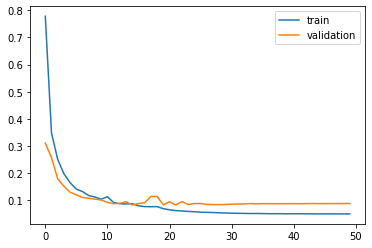

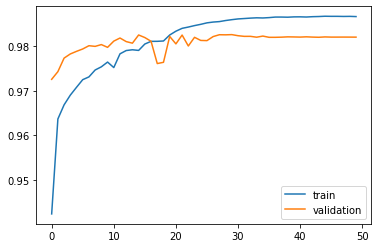

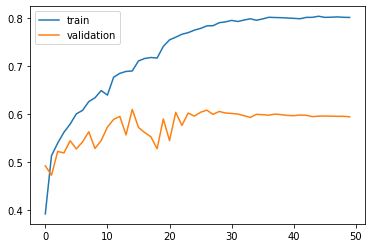

In [ ]:
[model, history] = train_fine_tuning() # fine tuning of EFF-Unet NO PEAD

In [ ]:
[model, history] = train_fine_tuning() # fine tuning of EFF-Unet all the dataset 1248 fine tuned from 4

--------------------------------------------
Image heigth                      ---> 896
Image width                       ---> 1280
Batch size                        ---> 2
Learning rate                     ---> 5e-05
Number of epochs                  ---> 100
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 896, 1280, 3 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 896, 1280, 3) 0           input_5[0][0]                    
____

KeyboardInterrupt: ignored

# To train

In [ ]:
[model, history] = train_fine_tuning() # fine tuning of EFF-Unet all the dataset 512x512 PATCH stride 1

--------------------------------------------
Image heigth                      ---> 512
Image width                       ---> 512
Batch size                        ---> 16
Learning rate                     ---> 5e-05
Number of epochs                  ---> 50
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_13 (Rescaling)        (None, 512, 512, 3)  0           input_14[0][0]                   
____

# See predictions from the network

In [ ]:
apply_data_augmentation = True

img_h = int(1024)
img_w = int(1024)

num_classes = 3

bs = 6

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

model = define_transfer_learning(input_size = (img_h, img_w, 3)) #define_bonnet(input_size = (img_h, img_w, 3))

exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
model_name = 'eff-Unet_fine_tuning_block67' #'bonnet_rect'
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
#latest = tf.train.latest_checkpoint(ckpt_dir)
#print(latest)

model.load_weights('/content/drive/My Drive/Challenge_2/segmentation_experiments/eff-Unet_fine_tuning_block67/ckpts/cp_28.ckpt')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 896, 1280, 3 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 896, 1280, 3) 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 896, 1280, 3) 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 897, 1281, 3) 0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

In [ ]:
image, target = next(iterator)

(1, 896, 1280, 3)

(1, 896, 1280)


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(896, 1280), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>>

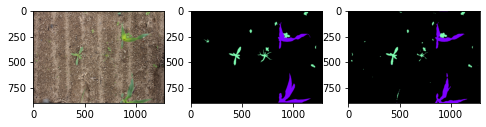

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape
print(tf.argmax(out_sigmoid, -1).shape)

predicted_class = predicted_class[0, ...]

predicted_class.numpy

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# Create prediction.json

In [ ]:
! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Challenge_2/Development_Dataset.zip
replace Development_Dataset/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Development_Dataset/LICENSE.txt  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/H

In [ ]:
def rle_encode(img):
  '''
  img: numpy array, 1 - foreground, 0 - background
  Returns run length as string formatted
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  
  return ' '.join(str(x) for x in runs)

In [ ]:
import os
import json
import numpy as np
from PIL import Image

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

submission_dict = {}

for t in teams:
  for p in plants:

    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:
      
      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, img_name)
      img = Image.open(tmp_path).convert('RGB')
      
      img_name = img_name.split('.')[0]

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = [img.height, img.width]
      submission_dict[img_name]['team'] = t
      submission_dict[img_name]['crop'] = p
      submission_dict[img_name]['segmentation'] = {}

      # Resize image for the network
      w, h = img.size

      img_h = int(896)
      img_w = int(1280)
      img = img.resize((img_w, img_h)) #size – The requested size in pixels, as a 2-tuple: (width, height). !!!!!!!!!!! ATTENTION !!!!!!!!! PIL function

      # Getting the np array with the batch dimension
      img_array = np.array(img)
      
      # Data Normalization
      #img_array = mask_image(img_array)

      img_array = np.expand_dims(img_array, 0) # insert batch dimension

      # Prediction from the model
      out = model.predict(x=img_array)
      
      # Resize of the output
      out = tf.image.resize(out, size=[h, w], method = 'nearest').numpy()

      # Getting the numpy array with prediction
      mask_arr = tf.argmax(out, -1)
      mask_arr = mask_arr.numpy()
      
      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
      

# Finally, save the results into the submission.json file
with open('/content/submission.json', 'w') as f:
  json.dump(submission_dict, f)

! mkdir '/content/drive/My Drive/Challenge_2/submission'
! rm '/content/drive/My Drive/Challenge_2/submission/submission.json'
! cp '/content/submission.json' '/content/drive/My Drive/Challenge_2/submission/submission.json'

mkdir: cannot create directory ‘/content/drive/My Drive/Challenge_2/submission’: File exists


In [ ]:
# ---------------------------------------
# Script to check dimension of the images
# ---------------------------------------
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

sdict = {}

for t in teams:
  for p in plants:
    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:

      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, str(img_name))
      
      img = Image.open(tmp_path).convert('RGB')
      img_array = np.array(img)

      img_name = img_name.split('.')[0]

      sdict[img_name] = {}
      sdict[img_name]['shape'] = img_array.shape
      sdict[img_name]['team'] = t
      sdict[img_name]['crop'] = p

sdict

# Class weights

In [ ]:
def ENet_weighing(image_files, num_classes=4):
    '''
    The custom class weighing function as seen in the ENet paper.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #initialize dictionary with all 0
    label_to_frequency = {}
    for i in range(num_classes):
        label_to_frequency[i] = 0

    for n in range(len(image_files)):
        image = np.load(image_files[n])

        #For each label in each image, sum up the frequency of the label and add it to label_to_frequency dict
        for i in range(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            label_to_frequency[i] += class_frequency

    #perform the weighing function label-wise and append the label's class weights to class_weights
    class_weights = []
    total_frequency = sum(label_to_frequency.values())
    for label, frequency in label_to_frequency.items():
        class_weight = 1 / np.log(1.02 + (frequency / total_frequency))
        class_weights.append(class_weight)

    #Set the last class_weight to 0.0
 #   class_weights[-1] = 0.0

    return class_weights

def median_frequency_balancing(image_files, num_classes=3):
    '''
    Perform median frequency balancing on the image files, given by the formula:
    f = Median_freq_c / total_freq_c
    where median_freq_c is the median frequency of the class for all pixels of C that appeared in images
    and total_freq_c is the total number of pixels of c in the total pixels of the images where c appeared.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    - num_classes(int): the number of classes of pixels in all images
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    # Initialize all the labels key with a list value
    label_to_frequency_dict = {}
    for i in range(num_classes):
        label_to_frequency_dict[i] = []

    for n in range(len(image_files)):
      image = np.load(image_files[n])

      #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
      for i in range(num_classes):
        class_mask = np.equal(image, i)
        class_mask = class_mask.astype(np.float32)
        class_frequency = np.sum(class_mask)

        if class_frequency != 0.0:
            label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)
    print('total_pixels=', total_pixels)
    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the last class_weight to 0.0 as it's the background class
 #   class_weights[-1] = 0.0

    return class_weights

In [ ]:
tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'training', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_training = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'validation', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_validation = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

image_files = []
for i in image_files_training:
  image_files.append(i)
for i in image_files_validation:
  image_files.append(i)
#print('image_files:', image_files)

print()

class_weights = median_frequency_balancing(image_files, num_classes = 3)
print('--------------------------------------------------------------------------------------------------------------')
print('median_frequency_balancing class_weights:', class_weights)
print('--------------------------------------------------------------------------------------------------------------')
class_weights = ENet_weighing(image_files, num_classes = 3)
print('ENet_weighing class_weights:', class_weights)

# Output of the functions
# -----------------------
# median_frequency_balancing class_weights: [0.0006417555956420423, 0.011047978584875455, 0.009338345742752394]
# -----------------------
# ENet_weighing class_weights: [1.5133127348818056, 14.139274748955497, 20.349217406952828]
# -----------------------


total_pixels= 9165394924.0
--------------------------------------------------------------------------------------------------------------
median_frequency_balancing class_weights: [0.0006417555956420423, 0.011047978584875455, 0.009338345742752394]
--------------------------------------------------------------------------------------------------------------
ENet_weighing class_weights: [1.5133127348818056, 14.139274748955497, 20.349217406952828]
